In [1]:
import os,sys
sys.path.append("../src/")
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, ADASYN
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import visualizations as visu
import language as lang
import evaluation as eval

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Descrição do modelo
- Proprocessamento melhorado: Melhorias NLP, TfidfVectorizer com ngram_range de 1 a 3 e 500 features tfidf;
- Features adicionais além do texto do post;
- Seleção de features com baixa variância;
- Reequilibrio das classes com SMOTE;
- Modelos de ML (sklearn) com Cross-validation.

## Loading data

In [2]:
# Loading the data
df_train = pd.read_csv('../data/Social Bias Frames/SBIC.v2.trn.csv')
df_valid = pd.read_csv('../data/Social Bias Frames/SBIC.v2.dev.csv')
df_test = pd.read_csv('../data/Social Bias Frames/SBIC.v2.tst.csv')

## Data Preparation:

In [3]:
target_col = 'targetCategory'

In [4]:
print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

df_train[target_col].value_counts(dropna=False)

train data: (112900, 19)
valid data: (16738, 19)
test data: (17501, 19)


NaN         70406
race        14987
gender      10872
culture      8843
victim       2680
disabled     2350
social       1730
body         1032
Name: targetCategory, dtype: int64

In [5]:
# Dropping nan values:
df_train = df_train.dropna(subset=[target_col]).reset_index(drop=True)
df_valid = df_valid.dropna(subset=[target_col]).reset_index(drop=True)
df_test = df_test.dropna(subset=[target_col]).reset_index(drop=True)

print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

train data: (42494, 19)
valid data: (8166, 19)
test data: (9200, 19)


In [6]:
# Concating train and valid dataframes and splitting X and y arrays:
df_train = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[[target_col]]

print('train data:', X_train.shape)
print('valid data:', X_test.shape)

train data: (50660, 18)
valid data: (9200, 18)


In [7]:
# Encoding the y targets:
le = LabelEncoder()
y_train[target_col] = le.fit_transform(y_train[target_col])
y_test[target_col] = le.transform(y_test[target_col])

<ipython-input-7-b59cab9b584f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[target_col] = le.fit_transform(y_train[target_col])
<ipython-input-7-b59cab9b584f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[target_col] = le.transform(y_test[target_col])


## Pre-processing

In [8]:
# Creating some features
X_train['post_length'] = X_train['post'].apply(lambda x: len(x))
X_train['post_length_no_spaces'] = X_train['post'].apply(lambda x: len(x) - x.count(" "))

X_test['post_length'] = X_test['post'].apply(lambda x: len(x))
X_test['post_length_no_spaces'] = X_test['post'].apply(lambda x: len(x) - x.count(" "))

In [9]:
# Encoding text columns:
en_stp_words = stopwords.words('english')
max_features = 500

def column_vectorizer(df_train, df_test, col, analyzer, max_features=100, stop_words=stopwords.words('english')):
    corpus = df_train[col].values
    vectorizer = TfidfVectorizer(analyzer=analyzer, max_features=max_features)
    vectorizer.fit(corpus)

    df_train_tfidf = vectorizer.transform(df_train[col])
    tfidf_cols = [f'tfidf_{col}_{i}' for i in range(df_train_tfidf.shape[1])]
    df_train_tfidf = pd.DataFrame(df_train_tfidf.toarray(), columns=tfidf_cols)
    df_train = pd.concat([df_train, df_train_tfidf], axis=1)
    df_test_tfidf = vectorizer.transform(df_test[col])
    df_test_tfidf = pd.DataFrame(df_test_tfidf.toarray(), columns=tfidf_cols)
    df_test = pd.concat([df_test, df_test_tfidf], axis=1)
    
    return df_train, df_test, tfidf_cols
    
# post text:
X_train, X_test, tfidf_cols = column_vectorizer(X_train, X_test, 'post', analyzer=lang.clean_text_stem,
                                                max_features=max_features, stop_words=en_stp_words)


In [10]:
X_train

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,...,tfidf_post_490,tfidf_post_491,tfidf_post_492,tfidf_post_493,tfidf_post_494,tfidf_post_495,tfidf_post_496,tfidf_post_497,tfidf_post_498,tfidf_post_499
0,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50655,1.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,0.0,3169503690680674782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50656,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,955703508749055793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50657,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,955703508749055793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50658,1.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,0.0,-6352039173957003457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Encoding other columns:

# Features groups:
cat_features = ['dataSource']
num_float_features = ['post_length', 'post_length_no_spaces']
passthrough_features = [] + tfidf_cols

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                                                ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [12]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding),
                         ('feature selection var', VarianceThreshold(threshold=1e-3))])

In [13]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test.loc[:, X_train.columns])

In [14]:
print('X_train:', X_train.shape)
print('X_train_encoded:', X_train_encoded.shape)

X_train: (50660, 520)
X_train_encoded: (50660, 470)


## Dealing with the imbalance:

In [15]:
print(sorted(Counter(y_train[target_col]).items()))
X_train_encoded, y_train = SMOTE().fit_resample(X_train_encoded, y_train[target_col])
print(sorted(Counter(y_train).items()))

[(0, 1219), (1, 10498), (2, 2746), (3, 12667), (4, 18562), (5, 2008), (6, 2960)]
[(0, 18562), (1, 18562), (2, 18562), (3, 18562), (4, 18562), (5, 18562), (6, 18562)]


## Model Training

In [16]:
n_jobs = 4
n_iter = 50

estimators_list = []

In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
clf_rf.fit(X_train_encoded, y_train)
rf_metrics = pd.DataFrame(clf_rf.cv_results_)
estimators_list.append(clf_rf)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100, 800, 100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Create a based model
lrc = LogisticRegression()
# Instantiate the grid search model
clf_lrc = RandomizedSearchCV(estimator=lrc, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
clf_lrc.fit(X_train_encoded, y_train)
lrc_metrics = pd.DataFrame(clf_lrc.cv_results_)
estimators_list.append(clf_lrc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.57217535 0.71141527        nan 0.71023775 0.7113614  0.71036088
 0.71139218 0.67576639 0.70960664 0.71039935 0.70668977 0.71043783
        nan        nan 0.70960664        nan        nan 0.70967591
 0.70371904        nan 0.69947072        nan 0.70666668 0.71036088
        nan 0.67846003 0.41427994 0.58364275        nan        nan
 0.7103301         nan 0.41431842 0.58366584 0.6757587         nan
        nan 0.71053019 0.70670516 0.71125365        nan 0.41440308
 0.41427994 0.70368056 0.70372674 0.70364208 0.71036088 0.56942784
        nan        nan]
  warnings.warn(


In [19]:
# # Create the parameter grid based on the results of random search 
# param_grid = {'metric': ['minkowski', 'euclidean', 'manhattan'],
#               'weights': ['uniform', 'distance'],
#               'n_neighbors': np.array([3, 4, 5, 6, 7, 8, 9])}

# # Create a based model
# knn = KNeighborsClassifier()
# # Instantiate the grid search model
# clf_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
#                              cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
# clf_knn.fit(X_train_encoded, y_train)
# knn_metrics = pd.DataFrame(clf_knn.cv_results_)
# estimators_list.append(clf_knn)

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


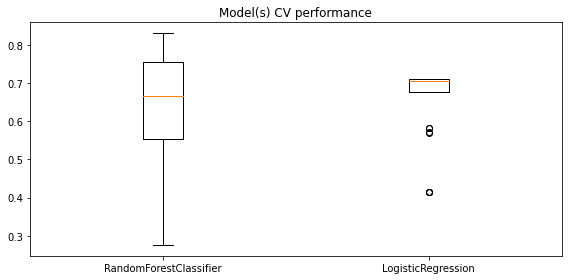

In [20]:
visu.plot_estimators_cvperf(estimators_list)

In [21]:
# Selecting the optimal model and Re-fiting with the whole training dataset:
estimators_cvperf = [pd.DataFrame(estimator.cv_results_)['mean_test_score'].max() for estimator in estimators_list]
clf_opt = estimators_list[np.argmax(estimators_cvperf)]

model = clf_opt.best_estimator_.fit(X_train_encoded, y_train)
model

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=8,
                       n_estimators=30)

## Evaluating the model

In [22]:
TARGET_NAMES = le.classes_
TARGET_NAMES

array(['body', 'culture', 'disabled', 'gender', 'race', 'social',
       'victim'], dtype=object)

Classes evaluated: ['body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim']
Correctly classified......: 6571/9200
Accuracy (simple) ........: 0.71
Balanced acc.  ...........: 0.60
Balanced acc. (adjusted)..: 0.53
Acc. norm (Recall avgs) ..: 0.60
Precision = tp / (tp + fp): [0.56 0.77 0.42 0.8  0.92 0.41 0.14] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.46 0.71 0.43 0.76 0.76 0.55 0.51] -> sensibility (true positive rate)
F1 score .................: [0.51 0.74 0.42 0.78 0.83 0.47 0.22] -> harmonic mean


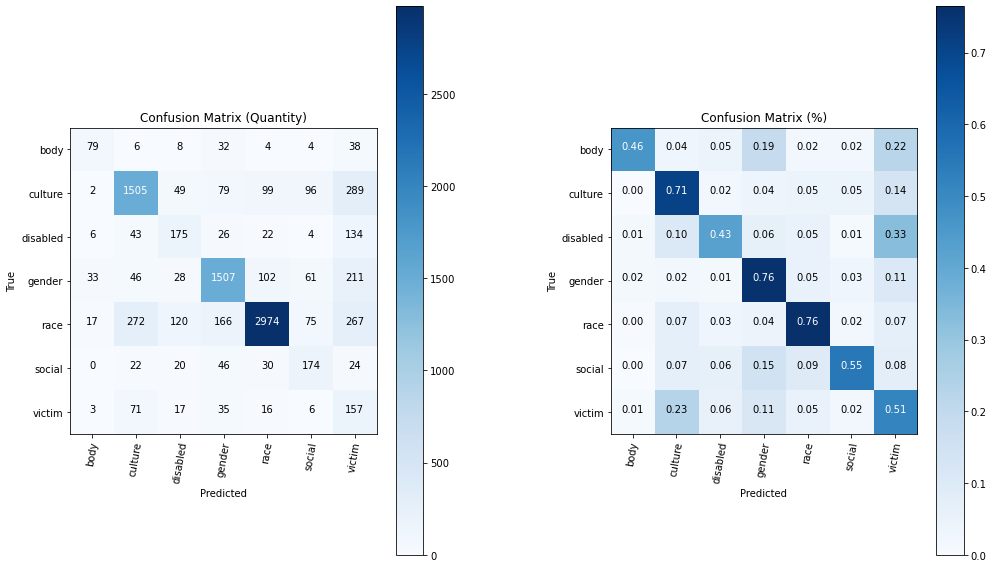

,accuracy,balanced_accuracy,balanced_accuracy adjusted,precision,recall,f1_score
0,0.71,0.60,0.53,0.56,0.46,0.51
1,0.71,0.60,0.53,0.77,0.71,0.74
2,0.71,0.60,0.53,0.42,0.43,0.42
3,0.71,0.60,0.53,0.80,0.76,0.78
4,0.71,0.60,0.53,0.92,0.76,0.83
5,0.71,0.60,0.53,0.41,0.55,0.47
6,0.71,0.60,0.53,0.14,0.51,0.22


In [23]:
y_pred_test = model.predict(X_test_encoded)
y_true_test = y_test[target_col].values

results = eval.performance_measures(y_true_test, y_pred_test, TARGET_NAMES)
results = pd.DataFrame(results)
results

../src\evaluation.py:149: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
../src\evaluation.py:150: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
../src\evaluation.py:152: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
../src\evaluation.py:153: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


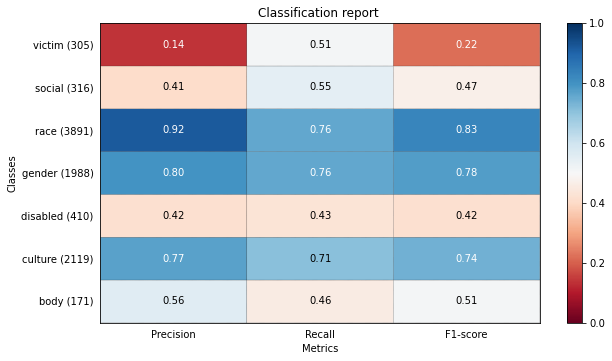

In [24]:
eval.plot_classification_report(classification_report(y_true_test, y_pred_test, target_names=TARGET_NAMES))